# Notebook Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Math


import numpy as np
import matplotlib.pyplot as plt

import os
import sys

sys.path.insert(1, '../')

from moments_toolkit import moments_toolkit

from moments_toolkit import ratio_formula, sum_ratios_formula

import gvar as gv

from moments_toolkit import plateau_search

import itertools as it

import correlatoranalyser as CA

from moments_toolkit import average_moments_over_T
from moments_toolkit import jackknife, jackknife_resamples

In [2]:
p3fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/3PointCorrelation/"
p2fold = os.environ['mount_point_path'] + "48c48/binned_1012_hmz370_BMW_extended/2PointCorrelation/"


opAnalyzer = moments_toolkit(p3fold, p2fold,
                            skip3p=False, skipop=False,
                            verbose=True,
                            fast_data_folder = "../fast_data_extended_p0_q0",
                            operator_folder= "../operator_database",
                            momentum='PX0_PY0_PZ0',
                            insertion_momentum = 'qx0_qy0_qz0',
                            tag_2p='hspectrum',
                            max_n=2 #max_n=3
                            )

#opAnalyzer = moments_toolkit(p3fold, p2fold,
#                            skip3p=False, skipop=False,
#                            verbose=True,
#                            fast_data_folder = "../fast_data_extended_px-2_q0",
#                            operator_folder= "../operator_database",
#                            momentum='PX-2_PY0_PZ0',
#                            insertion_momentum = 'qx0_qy0_qz0',
#                            tag_2p='hspectrum',
#                            max_n=2 #max_n=3
#     


Initializing the moments_toolkit class instance...


Initializing the building block class instance...


Reading the the keys of the dataset ...


Reading the 2 point and 3 point correlators from the fast access dataset ...


Reading the list of all the available operators from the database...


Class Initialization Complete!



In [3]:
opAnalyzer.set_resampling_type('jackknife')
opAnalyzer.set_fit_parms(central_value_fit=True, central_value_fit_correlated=True, resample_fit=False, resample_fit_correlated=False)

In [4]:
#we take the operators of the paper

opV1 = 1/6 * opAnalyzer.get_operator(2)
opV2 = 1/(3 * np.sqrt(2)) * (opAnalyzer.get_operator(2) - opAnalyzer.get_operator(3))
opV3 = 1/np.sqrt(2) * opAnalyzer.get_operator(14)

opA1 = 1/np.sqrt(2) * opAnalyzer.get_operator(28)
opA2 = 1/np.sqrt(2) * opAnalyzer.get_operator(32)

opT1 = opAnalyzer.get_operator(74) + 1/2 * opAnalyzer.get_operator(78)
opT2 = opAnalyzer.get_operator(78)
opT3 =  1/6 * ( -3 * opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) + 3* opAnalyzer.get_operator(91) + opAnalyzer.get_operator(95) )
opT4 = 1/2 * ( opAnalyzer.get_operator(83) + 2 * opAnalyzer.get_operator(87) -2* opAnalyzer.get_operator(91) )



#we empty the selected op just to be sure
opAnalyzer.deselect_operator()

#we append the operators
opAnalyzer.append_operator(opV1)
opAnalyzer.append_operator(opV2)
opAnalyzer.append_operator(opV3)
opAnalyzer.append_operator(opA1)
opAnalyzer.append_operator(opA2)
opAnalyzer.append_operator(opT1)
opAnalyzer.append_operator(opT2)
opAnalyzer.append_operator(opT3)
opAnalyzer.append_operator(opT4)

#opAnalyzer.append_operator(opAnalyzer.get_operator(125))


#we deselect the op with 0 kin factor
Klist = opAnalyzer.get_Klist()
eliminate_op = [op for op,kin in zip(opAnalyzer.selected_op,Klist) if np.abs( kin.mean ) == 0]
for op in eliminate_op:
    opAnalyzer.deselect_operator(op)
Klist = opAnalyzer.get_Klist()


opAnalyzer.display_operators()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# One Operator Analysis

In [5]:
iop = 0

## Single T fits

In [6]:
#opAnalyzer.remove_T(12,verbose=True)
Rmean,Rstd,Rcov = opAnalyzer.get_R()

"(Nop,NT,maxT+1)"
Rmean.shape

Tlist = opAnalyzer.chosen_T_list
Tlist

'(Nop,NT,maxT+1)'

(5, 8, 13)

[3, 4, 5, 6, 7, 8, 10, 12]

In [7]:
class one_T_func:

    def __init__(self,T:int):
        self.T = T
        
    def __call__(self, tau:int, parms:dict):

        dE = np.exp( parms["log(dE)"] ) if "log(dE)" in parms else parms["dE"]

        return parms["c1"] + parms["c2"] * np.cosh( (self.T/2 - tau) * dE )

In [8]:
np.arange(1,)

array([0])

In [9]:
opAnalyzer.chosen_T_list

[3, 4, 5, 6, 7, 8, 10, 12]

np.float64(0.7175149525509775)

{7: 1, 10: 1, 12: 1}

{7: np.float64(-0.6288600228190062),
 10: np.float64(-0.37303083193003106),
 12: np.float64(-0.2967386873629178)}

{7: np.float64(0.695729464768097),
 10: np.float64(0.43113009348571407),
 12: np.float64(0.3501039731003575)}

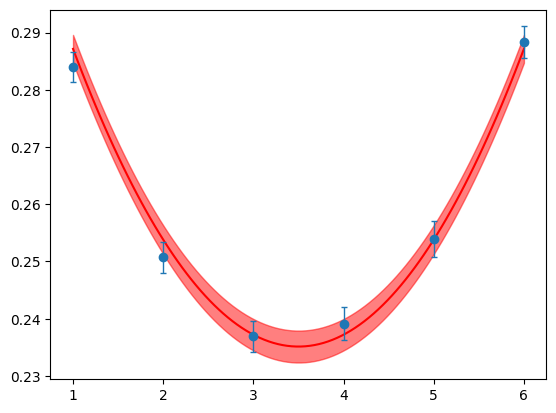

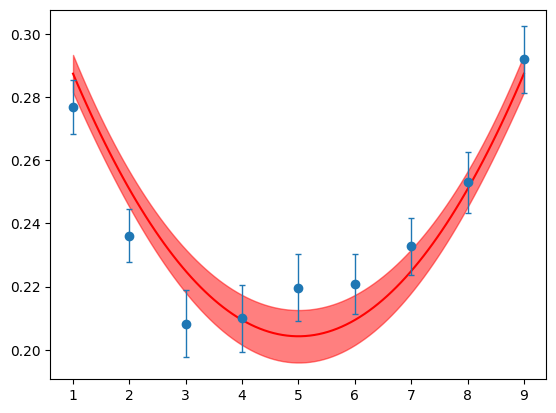

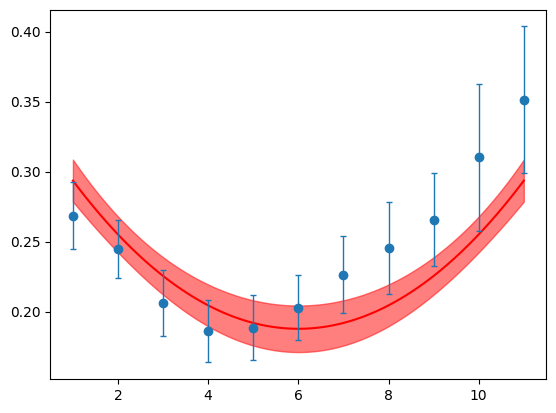

In [10]:
#useful dict
cut_dict = {}
c1_dict = {}
c2_dict = {}

m_r1_list = []

plot = True


#loop over T
for iT, T in enumerate(opAnalyzer.chosen_T_list):
    
    #we start from cut=1 since we have to cut the endpoints anyway
    for icut in range(1,int(T/2)):

        #we get the abscissa of the fit
        abscissa = np.arange(icut,T+1-icut)
        #we get the ordinate of the fit
        ordinate = Rmean[iop,iT,icut:T+1-icut]
        ordinate_std = Rstd[iop,iT,icut:T+1-icut]
        ordinate_cov = Rcov[iop,iT,icut:T+1-icut,icut:T+1-icut]

        #we asses the number of data points and parameters
        Ndata = len(abscissa)
        Nparams = 3 #c1,c2,dE

        #we skip the fit if the number of data points is not enough
        if Ndata <= Nparams+1: break

        #we asses the prior of the fit
        prior = gv.BufferDict()

        dE1 = opAnalyzer.get_dE()
        prior["log(dE)"] = np.log( gv.gvar(dE1) )

        i_probe1 = int(len(abscissa)/2-1)
        i_probe2 = int(len(abscissa)/2 + T%2) #to avoid dividing by zero with odd numbers
        #i_probe1, i_probe2,# abscissa, ordinate
        #T,T/2,abscissa[i_probe1], abscissa[i_probe2]
        c2_mean = (ordinate[i_probe1] - ordinate[i_probe2] ) / ( np.cosh( (T/2 - abscissa[i_probe1] ) * dE1.mean ) - np.cosh( (T/2 - abscissa[i_probe2]) * dE1.mean ) )
        c1_mean = ordinate[i_probe2] - c2_mean * np.cosh( (T/2 - abscissa[i_probe2]) * dE1.mean )

        prior["c1"] = gv.gvar(c1_mean, c1_mean)
        prior["c2"] = gv.gvar(c2_mean, c2_mean)

        #we perform the fit
        fit_res = CA.fit(

        abscissa                = np.ascontiguousarray( abscissa ),
        
        ordinate_est            = np.ascontiguousarray( ordinate ) ,
        ordinate_std            = np.ascontiguousarray( ordinate_std ),
        ordinate_cov            = np.ascontiguousarray( ordinate_cov ),
        
        resample_ordinate_est   = None,
        resample_ordinate_std   = None,
        resample_ordinate_cov   = None,

        # fit strategy, default: only uncorrelated central value fit:
        central_value_fit            = True,
        central_value_fit_correlated = True,

        resample_fit                 = False,#True,
        resample_fit_correlated      = False,#True,
        
        resample_fit_resample_prior  = False,
        resample_type               = None,

        # args for lsqfit:
        model   = one_T_func(T),
        prior   = prior,
        p0      = None,

        svdcut  = None,
        maxiter = 10_000,
        )


        #if the chi2/dof is smaller than 1 we save the data and go to the next T
        if fit_res.chi2 / fit_res.Ndata <=5.0:
            cut_dict[T] = icut
            c1_dict[T] = fit_res.result_params()["est"]["c1"]
            c2_dict[T] = fit_res.result_params()["est"]["c2"]
            m_r1_list.append( fit_res.result_params()["est"]["c2"] * np.exp(T/2 * dE1.mean) )

            if plot:

                plot_abscissa = np.linspace(min(abscissa),max(abscissa),100)
                best_fit_R = gv.gvar(fit_res.eval(plot_abscissa)["est"], fit_res.eval(plot_abscissa)["err"]) / Klist[iop]
                fity_low = np.asarray( [ y.mean - y.sdev for y in best_fit_R])
                fity_high = np.asarray( [ y.mean + y.sdev for y in best_fit_R])
                fity = np.asarray( [ y.mean for y in best_fit_R])

                _=plt.figure()

                _=plt.fill_between(plot_abscissa, fity_low, fity_high, alpha=0.5, color="red")
                _=plt.plot(plot_abscissa,fity,color="red")
                _=plt.errorbar(abscissa,ordinate/Klist[iop].mean,ordinate_std/np.abs(Klist[iop].mean),marker='o',linewidth=0,elinewidth=1,capsize=2)



            break


m_r1_mean = np.mean(m_r1_list)
m_r1_mean

cut_dict
c1_dict
c2_dict

In [11]:
#we create the data for completly corelated fit
abscissa = []
ordinate = []
ordinate_std = []

for iT, T in enumerate(opAnalyzer.chosen_T_list):

    if T in cut_dict:
        cut = cut_dict[T]
        oneT_abscissa = np.arange(cut,T+1-cut)
        oneT_ordinate = Rmean[iop,iT,cut:T+1-cut]
        oneT_ordinate_std = Rstd[iop,iT,cut:T+1-cut]

        for a,o,s in zip(oneT_abscissa,oneT_ordinate,oneT_ordinate_std):
            abscissa.append((T,T/2-a))
            ordinate.append(o)
            ordinate_std.append(s)

abscissa = np.asarray(abscissa, dtype=float)
ordinate = np.asarray(ordinate)
ordinate_std = np.asarray(ordinate_std)

abscissa
ordinate
ordinate_std

array([[ 7. ,  2.5],
       [ 7. ,  1.5],
       [ 7. ,  0.5],
       [ 7. , -0.5],
       [ 7. , -1.5],
       [ 7. , -2.5],
       [10. ,  4. ],
       [10. ,  3. ],
       [10. ,  2. ],
       [10. ,  1. ],
       [10. ,  0. ],
       [10. , -1. ],
       [10. , -2. ],
       [10. , -3. ],
       [10. , -4. ],
       [12. ,  5. ],
       [12. ,  4. ],
       [12. ,  3. ],
       [12. ,  2. ],
       [12. ,  1. ],
       [12. ,  0. ],
       [12. , -1. ],
       [12. , -2. ],
       [12. , -3. ],
       [12. , -4. ],
       [12. , -5. ]])

array([0.08077707, 0.07130614, 0.06737783, 0.06800486, 0.0722017 ,
       0.08198425, 0.07876194, 0.06713494, 0.05923685, 0.05972553,
       0.06247919, 0.06279275, 0.06621782, 0.07195474, 0.08301521,
       0.0763431 , 0.06955904, 0.05852652, 0.0528968 , 0.05357416,
       0.05768961, 0.06431942, 0.06980704, 0.07552153, 0.08818065,
       0.0998927 ])

array([0.00075063, 0.00076073, 0.00078238, 0.0008287 , 0.00088684,
       0.00078822, 0.00243958, 0.00239247, 0.0030114 , 0.00302285,
       0.0030058 , 0.00267434, 0.00255931, 0.00272705, 0.00297172,
       0.00679597, 0.00597095, 0.00669368, 0.00637925, 0.00659464,
       0.00660771, 0.0078341 , 0.00930993, 0.00944789, 0.01485298,
       0.01491735])

In [12]:
class ratio_func_form:

    def __init__(self,r1:bool=True,r2:bool=True,r3:bool=False):
        self.r1:bool=r1
        self.r2:bool=r2
        self.r3:bool=r3
        
    def __call__(self, t:tuple[int,int], parms:dict):

        #we grep the input
        T = t[:,0]
        T_tau = t[:,1]
        MatEle = parms["M"]
        #R1 = parms["R1"]
        R1 = np.exp( parms["log(R1)"] ) if "log(R1)" in parms else parms["R1"]
        R2 = parms["R2"]
        R3 = np.exp( parms["log(R3)"] ) if "log(R3)" in parms else parms["R3"]
        dE = np.exp( parms["log(dE)"] ) if "log(dE)" in parms else parms["dE"]

        out = MatEle

        fact = 1.0

        if self.r1:
            fact += R1 * np.exp(-T/2*dE)* np.cosh( T_tau * dE)
        if self.r2:
            fact += R2 * np.exp(-T*dE)

        if self.r3:
            fact /= (1 + R3 * np.exp(-T*dE))

        return out*fact

In [13]:
prior = gv.BufferDict()

#dE
dE1 = opAnalyzer.get_dE()
prior["log(dE)"] = np.log( gv.gvar(dE1) )

#M
matele_fromS = opAnalyzer.get_M_from_S(method="fit", tskip_list=[1,2,3],moments=False)
mat_ele_avg, iTmin  = average_moments_over_T(matele_fromS[iop], chi2=1.0)
prior["M"] = gv.gvar(mat_ele_avg.mean,mat_ele_avg.sdev * 10)

#r1
R1_mean = m_r1_mean/ mat_ele_avg.mean
prior["R1"] = gv.gvar(R1_mean, R1_mean/2)

#r2
prior["R2"] = gv.gvar(R1_mean, R1_mean) /2

#r3
prior["log(R3)"] = np.log( gv.gvar(R1_mean, R1_mean) /2 )

prior


BufferDict({'log(dE)': -2.497(17), 'M': 0.0614(65), 'R1': 11.7(5.8), 'R2': 5.8(5.8), 'log(R3)': 1.8(1.0)})

In [14]:
fit_res = CA.fit(

    abscissa                = abscissa,
    
    ordinate_est            = ordinate,
    ordinate_std            = ordinate_std,
    ordinate_cov            = None,
    
    resample_ordinate_est   = None,
    resample_ordinate_std   = None,
    resample_ordinate_cov   = None,

    # fit strategy, default: only uncorrelated central value fit:
    central_value_fit            = True,
    central_value_fit_correlated = False,

    resample_fit                 = False,#True,
    resample_fit_correlated      = False,#True,
    
    resample_fit_resample_prior  = False,
    resample_type               = None,

    # args for lsqfit:
    model   = ratio_func_form(r1=True,r2=True,r3=True),
    prior   = prior,
    p0      = None,

    svdcut  = None,
    maxiter = 10_000,
)

In [15]:
fit_res.best_fit_param["M"] /Klist[iop]

0.057(18)

In [16]:
fit_res.chi2 / fit_res.Ndata

15.1306817031029

In [17]:
best_fit_R = gv.gvar(fit_res.eval(abscissa)["est"], fit_res.eval(abscissa)["err"]) / Klist[iop]

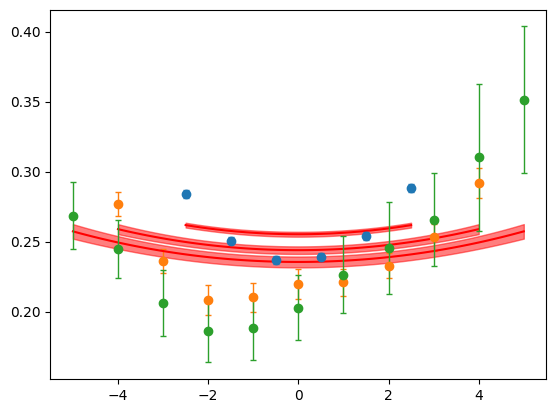

In [18]:
for iT, T in enumerate(opAnalyzer.chosen_T_list):

    if T in cut_dict:
        cut = cut_dict[T]
        oneT_abscissa = np.arange(cut,T+1-cut)
        oneT_ordinate = Rmean[iop,iT,cut:T+1-cut] / Klist[iop].mean
        oneT_ordinate_std = Rstd[iop,iT,cut:T+1-cut] / np.abs(Klist[iop].mean)

        eval_abs = np.asarray( [(T,T/2-tau) for tau in np.linspace(min(oneT_abscissa),max(oneT_abscissa),100) ] )
        best_fit_R = gv.gvar(fit_res.eval(eval_abs)["est"], fit_res.eval(eval_abs)["err"]) / Klist[iop]

        plot_abscissa = np.linspace(min(oneT_abscissa)-T/2,max(oneT_abscissa)-T/2,100)

        fity_low = np.asarray( [ y.mean - y.sdev for y in best_fit_R])
        fity_high = np.asarray( [ y.mean + y.sdev for y in best_fit_R])
        fity = np.asarray( [ y.mean for y in best_fit_R])

        _=plt.fill_between(plot_abscissa, fity_low, fity_high, alpha=0.5, color="red")
        _=plt.plot(plot_abscissa,fity,color="red")
        _=plt.errorbar(oneT_abscissa-T/2,oneT_ordinate,oneT_ordinate_std,marker='o',linewidth=0,elinewidth=1,capsize=2)